<a href="https://colab.research.google.com/github/wwidjaja0/ucla-ajl-7/blob/main/UCLA_AJL_Team_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UCLA AJI Team 7**



---


**Resources and Documents:**  
[Notion](https://www.notion.so/team/18610071-e06a-812f-98e5-004281f76263/join) | [Google Drive](https://drive.google.com/drive/folders/1uNRJqQwA9hGX1WO9Tq-dfMP-ASt_dR5L?usp=sharing) | [Github Repo](https://github.com/wwidjaja0/ucla-aji-7)

---

**Summary**

## **How to contribute to this Colab**
Every time you make contributions/changes to this file, please follow the steps below for version control.

### 1. Click save a copy in GitHub

![saveacopy.png](https://i.imghippo.com/files/GqN7306fLg.png)

### 2. MAKE SURE YOU'RE SAVING IT TO THE RIGHT REPO (it should be <your username>/ucla-ajl-7)
### 3. Feel free to add a commit message to let others know/for documentation what you changed/did.

![commit.png](https://i.imghippo.com/files/JOJ9352xYs.png)

## **1. Setup Data**

### File Structure Setup + Kaggle API Connection

In [25]:
! pip install -q kaggle # install kaggle library

In [26]:
# Upload your kaggle.json to access the Kaggle API from your account:
from google.colab import files
import os

if not os.path.exists('./kaggle.json'):
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json

In [27]:
if not os.path.exists('./train.csv'):
  ! kaggle competitions download -c bttai-ajl-2025 # Attempt to download the bttai-ajl-2025.zip
  ! unzip -q bttai-ajl-2025.zip # unzip the downloaded competition folder

In [28]:
if os.path.exists('./bttai-ajl-2025.zip'):
  ! rm bttai-ajl-2025.zip # cleanup
if os.path.exists('./sample_data/'):
  ! rm -rf sample_data # cleanup

### Generate Pandas Dataframes from train/test CSV files

In [29]:
import pandas as pd

# Load the data
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [30]:
# Check the first few rows to understand the structure
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


## **2. Analyzing and Preprocessing the Data**

<Axes: xlabel='fitzpatrick_scale'>

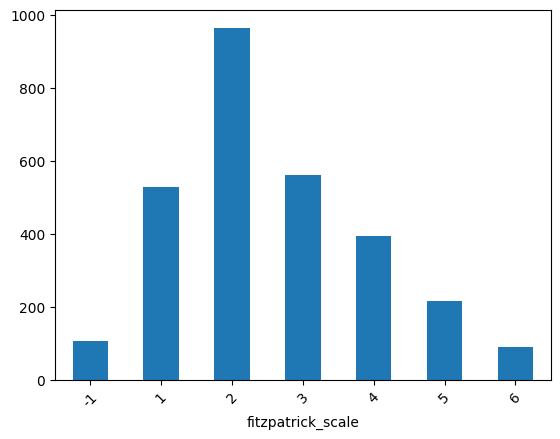

In [31]:
train_df["fitzpatrick_scale"].value_counts().sort_index().plot(kind="bar", rot=45)

<ipython-input-32-fa15a8dd03f8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(train_df, x='fitzpatrick_scale', y='label', inner='box', palette='Dark2')


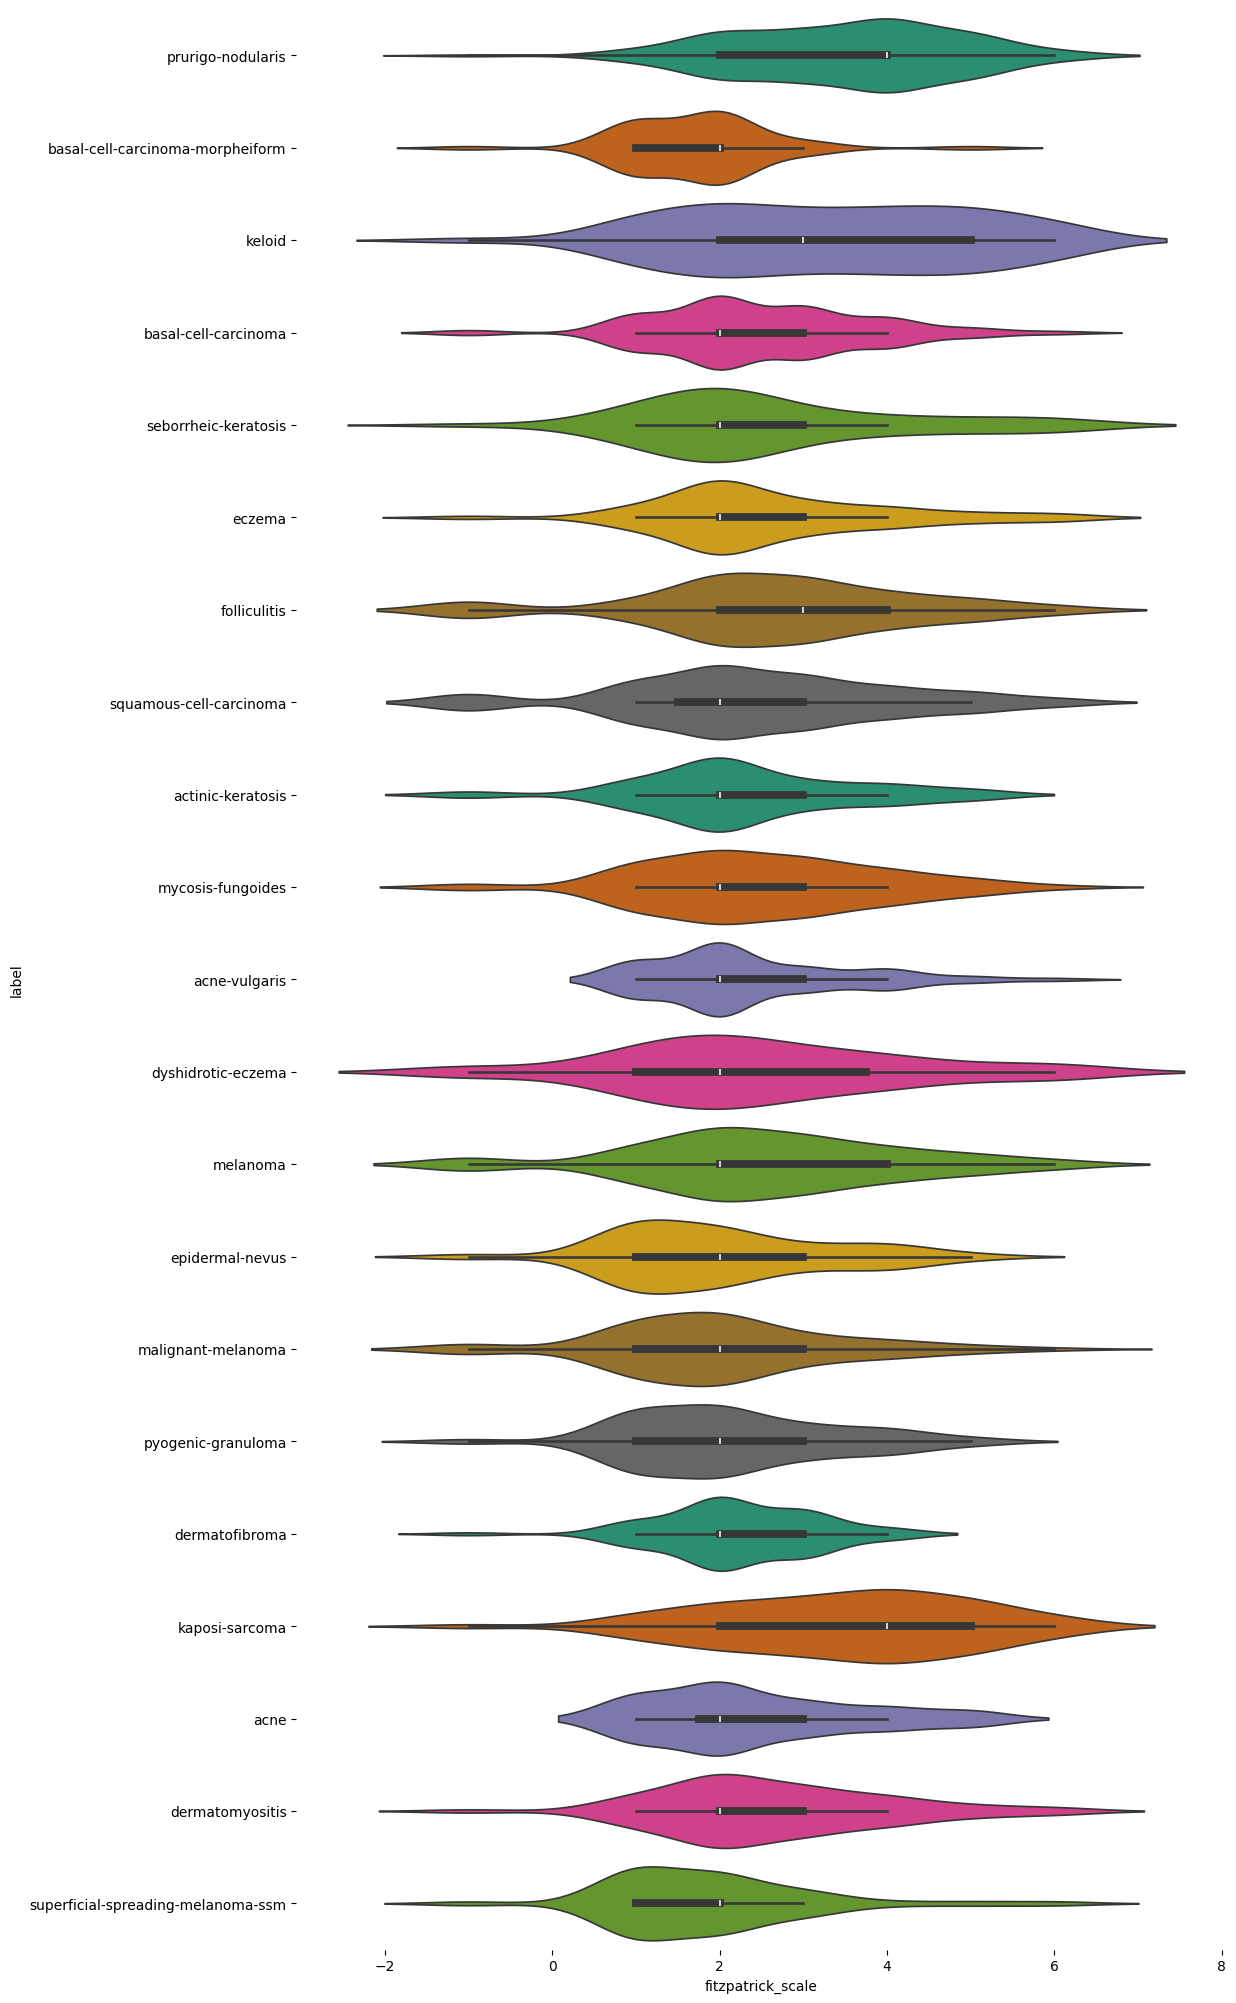

In [32]:
# @title Label vs Fitzpatrick Scale

from matplotlib import pyplot as plt
import seaborn as sns

figsize = (12, 1.2 * len(train_df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(train_df, x='fitzpatrick_scale', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Some follow-up questions for the data above:
1. Which images have the most imbalanced Fitzpatrick scores?
2. What should we do to balance the images under those labels?

### Data Augmentation

In [33]:
"""transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(),
  transforms.RandomHorizontalFlip(),
  transforms.CenterCrop(size=224), # Image net standards
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406],
                       [0.229, 0.224, 0.225])
])"""

'transform = transforms.Compose([\n  transforms.ToPILImage(),\n  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),\n  transforms.RandomRotation(degrees=15),\n  transforms.ColorJitter(),\n  transforms.RandomHorizontalFlip(),\n  transforms.CenterCrop(size=224), # Image net standards\n  transforms.ToTensor(),\n  transforms.Normalize([0.485, 0.456, 0.406],\n                       [0.229, 0.224, 0.225])\n])'

## **3. Build Model**

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 3. Data Preprocessing
# Encode the labels
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = './train/train/'

In [35]:
def create_generator(dataframe, directory, batch_size=32, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',  # Use combined path
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [36]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 2288 non-validated image filenames belonging to 21 classes.
Found 572 non-validated image filenames belonging to 21 classes.


In [37]:
x_batch, y_batch = next(iter(train_generator))
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: (32, 128, 128, 3)
y_batch shape: (32, 21)


In [38]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 21

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,349 (12.62 MB)

 Trainable params: 3,307,349 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

### RESNET?

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2

tf.keras.applications.ResNet152V2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(00000000000000, 000000000000, 3))

## **4. Train Model**

In [39]:
# TODO: Train your model here.
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1098 - loss: 2.9890 - val_accuracy: 0.1469 - val_loss: 2.8128
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.1270 - loss: 2.9088 - val_accuracy: 0.1294 - val_loss: 2.8158
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1308 - loss: 2.8478 - val_accuracy: 0.1783 - val_loss: 2.7662
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.1464 - loss: 2.8140 - val_accuracy: 0.2063 - val_loss: 2.6558
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.1679 - loss: 2.7427 - val_accuracy: 0.2063 - val_loss: 2.6300
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.1890 - loss: 2.6567 - val_accuracy: 0.2133 - val_loss: 2.6216
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.2134 - loss: 2.5413 - val_accuracy: 0.2150 - val_loss: 2.6135
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.2297 - loss: 2.4982 - val_accuracy: 0.2255 - va

In [45]:
model.save("CNNmodel1.h5")

### Model Evaulation

In [ ]:
"""from sklearn.metrics import accuracy_score

# Example ground truth labels and predictions grouped by skin type
y_true = [0, 1, 1, 2, 2, 2, 1, 0, 1, 2]  # Actual labels
y_pred = [0, 1, 0, 2, 2, 2, 1, 0, 1, 1]  # Model predictions
fitzpatrick_types = [1, 2, 3, 3, 4, 5, 5, 6, 6, 6]  # Fitzpatrick types per image

# Compute accuracy per Fitzpatrick Type
df_eval = pd.DataFrame({"true": y_true, "pred": y_pred, "fitzpatrick": fitzpatrick_types})
accuracy_per_type = df_eval.groupby("fitzpatrick").apply(lambda x: accuracy_score(x["true"], x["pred"]))

print(accuracy_per_type)"""

## **5. Make Predictions on Test Data**

In [49]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory):
    """
    Template for loading and preprocessing test images.
    """
    # TODO: create a generator for the test set here.
    # test_datagen = ImageDataGenerator(rescale=1./255)
    # test_generator = test_datagen.flow_from_dataframe(
    #     .... ## set the test_generator here
    # )
    # return test_generator
    test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col="md5hash",  # Ensure this column exists in test_df
        target_size=(128, 128),  # Match model input size
        batch_size=10,  # Adjust batch size based on memory
        class_mode=None,  # No labels since we are predicting
        shuffle=False  # Keep order for correct mapping
    )

    return test_generator

In [51]:
# Load test data
# test_dir = './test/test/'
# # test_generator = preprocess_test_data(test_df, test_dir)

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.applications import EfficientNetB0

# First define any custom classes/functions if needed
class Cast(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Cast, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

# Register custom objects, this is neeeded for the model I found, we will change this in the future
custom_objects = {
    'Cast': Cast,
    'EfficientNetB0': EfficientNetB0,
}

# Update the custom objects registry
get_custom_objects().update(custom_objects)

# Load the model with custom objects
model = load_model(
    "./CNNmodel1.h5",
    custom_objects=custom_objects
)

test_dir = os.path.join('./test/test/')
test_generator = preprocess_test_data(test_df, test_dir)
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
test_df["predictions"] = predicted_labels

Found 1227 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step


## **6. Generate Predictions**

In [52]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission

# Load the sample submission file
sample_submission = pd.read_csv("./sample_submission.csv")

# Generate predictions
predictions = model.predict(test_generator)  # Output is a probability distribution

# Convert probabilities to class indices
predicted_indices = np.argmax(predictions, axis=1)  # Get the index of the highest probability

# Convert indices back to class names using label encoder
predicted_labels = label_encoder.inverse_transform(predicted_indices)  # Convert to class names

# Ensure predictions match the format of sample_submission
submission = sample_submission.copy()
submission.iloc[:, 1] = predicted_labels  # Assign class names

# Save the corrected predictions to CSV
submission.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv with class labels!")

123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step
Predictions saved to submission.csv with class labels!
